**Team 21**

Praanshu Patel (23110249)

Rishank Soni (23110277)

Repository link: https://github.com/Praanshu101/Model_Checkpointing

Open in colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Praanshu101/Model_Checkpointing/blob/main/Model_Checkpointing.ipynb)

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1: Dataset Preparation

#### Getting files

In [3]:
import os

# Importing files
if os.path.exists("train.tsv"):
    print("File exists")
else:
    !wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv

if os.path.exists("test.tsv"):
    print("File exists")
else:
    !wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv

if os.path.exists("IMDB-Dataset.csv"):
    print("File exists")
else:
    !wget https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv


File exists
File exists
File exists


##### Loading Dataset 1 (tsv files)

In [4]:
# Loading the datasets
import pandas as pd
import numpy as np

def extractfiles(file):
    df = pd.read_csv(file, sep='\t', header=None)
    df.columns = ['text', 'label']

    # Extracting text
    df['text'] = df['text'].astype(str).apply(lambda x: x.replace('\t', ''))

    # Extracting labels
    df['label'] = df['label'].astype(str).apply(lambda x: x.replace('\n', ''))
    df['label'] = df['label'].astype(int)

    # Printing counts to ensure no imbalance of classes
    print("Counts of each label:")
    print(df['label'].value_counts())

    df.head(10)

    return df

traindf = extractfiles("train.tsv") 
test = extractfiles("test.tsv")

Counts of each label:
label
1    3610
0    3310
Name: count, dtype: int64
Counts of each label:
label
0    912
1    909
Name: count, dtype: int64


##### Splitting train data (from Dataset 1) into train and validation

In [5]:
# Split the dataset 1 into train and validation
from sklearn.model_selection import train_test_split

train, val = train_test_split(traindf, test_size=0.2, random_state=11)
print(f"Train shape: {train.shape}, Validation shape: {val.shape}")

train.head()

Train shape: (5536, 2), Validation shape: (1384, 2)


,text,label
1934,"for those in search of something different , w...",1
3425,"yes , mibii is rote work and predictable , but...",1
6025,this is an insultingly inept and artificial ex...,0
6478,"plunges you into a reality that is , more ofte...",1
1084,the problem with the mayhem in formula 51 is n...,0


##### Loading Dataset 2 (IMDB)

In [6]:
# Load IMDB dataset
imdb = pd.read_csv("IMDB-Dataset.csv")
imdb = imdb.rename(columns={"review": "text", "sentiment": "label"})
imdb['label'] = imdb['label'].apply(lambda x: 1 if x == 'positive' else 0)

# Printing counts to ensure no imbalance of classes
print("Counts of each label:")
print(imdb['label'].value_counts())

Counts of each label:
label
1    25000
0    25000
Name: count, dtype: int64


##### Splitting Dataset 2 into train and validation

In [7]:
# Train and validation split for IMDB dataset
imdb_train, imdb_val = train_test_split(imdb, test_size=0.2, random_state=11)
print(f"IMDB Train shape: {imdb_train.shape}, IMDB Validation shape: {imdb_val.shape}")

imdb_train.head()

IMDB Train shape: (40000, 2), IMDB Validation shape: (10000, 2)


,text,label
10024,Painful. Painful is the only word to describe ...,0
11762,This is a cute little French silent comedy abo...,1
43345,I loved this show when it aired on television ...,1
33685,It pains me to write such a scathing review bu...,0
23647,"""Stairway to Heaven"" is a outstanding inventio...",1


## 2: Model Construction

##### Model Architecture:

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Model architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(10000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        return x

##### Model Parameters:

In [9]:
# Instantiate model
model = NeuralNetwork()

# Print summary
from torchsummary import summary
summary(model, (1, 10000)) # 1 is the batch size and 10000 is the input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]       5,120,512
           Dropout-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
           Dropout-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
           Dropout-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 64]           8,256
           Dropout-8                [-1, 1, 64]               0
Total params: 5,292,992
Trainable params: 5,292,992
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.01
Params size (MB): 20.19
Estimated Total Size (MB): 20.24
----------------------------------------------------------------


In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 5293122


## 3: Bag-of-words

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words(train_texts, val_texts, test_texts, max_features=10000):
    """
    Convert text data into Bag-of-Words features.

    Parameters:
    - train_texts: list or pandas Series of training texts
    - val_texts: list or pandas Series of validation texts
    - test_texts: list or pandas Series of test texts
    - max_features: maximum number of features for CountVectorizer

    Returns:
    - train_features: numpy array of training features
    - val_features: numpy array of validation features
    - test_features: numpy array of test features
    - vectorizer: fitted CountVectorizer instance
    """
    # Instantiate CountVectorizer
    vectorizer = CountVectorizer(max_features=max_features)

    # Fit and transform the training data
    train_features = vectorizer.fit_transform(train_texts)
    train_features = train_features.toarray()

    # Transform the validation data
    val_features = vectorizer.transform(val_texts)
    val_features = val_features.toarray()

    # Transform the test data
    test_features = vectorizer.transform(test_texts)
    test_features = test_features.toarray()

    # Print the shapes (number of samples, number of features)
    print(f"Train features shape: {train_features.shape}")
    print(f"Validation features shape: {val_features.shape}")
    print(f"Test features shape: {test_features.shape}")

    # Print length of vocab
    print(f"Length of vocab: {len(vectorizer.vocabulary_)}")

    # Print feature names
    print("Feature names:")
    print(vectorizer.get_feature_names_out()[:5])

    return train_features, val_features, test_features, vectorizer

# Dataset 1
train_features, val_features, test_features, vectorizer = bag_of_words(train['text'], val['text'], test['text'])

# Dataset 2
imdb_train_features, imdb_val_features, _, _ = bag_of_words(imdb_train['text'], imdb_val['text'], test['text'])

Train features shape: (5536, 10000)
Validation features shape: (1384, 10000)
Test features shape: (1821, 10000)
Length of vocab: 10000
Feature names:
['000' '10' '100' '101' '103']
Train features shape: (40000, 10000)
Validation features shape: (10000, 10000)
Test features shape: (1821, 10000)
Length of vocab: 10000
Feature names:
['00' '000' '007' '10' '100']


##### Converting arrays to tensors

In [12]:
def convert_to_tensors(train_features, val_features, test_features, train_labels, val_labels, test_labels):
    # Convert the features to tensors
    train_features = torch.tensor(train_features, dtype=torch.float32)
    val_features = torch.tensor(val_features, dtype=torch.float32)
    test_features = torch.tensor(test_features, dtype=torch.float32)

    # Convert the labels to tensors
    train_labels = torch.tensor(train_labels, dtype=torch.int64)
    val_labels = torch.tensor(val_labels, dtype=torch.int64)
    test_labels = torch.tensor(test_labels, dtype=torch.int64)

    # Print the shapes
    print(f"Train features shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
    print(f"Validation features shape: {val_features.shape}, Validation labels shape: {val_labels.shape}")
    print(f"Test features shape: {test_features.shape}, Test labels shape: {test_labels.shape}")

    return train_features, val_features, test_features, train_labels, val_labels, test_labels

# Dataset 1
train_features, val_features, test_features, train_labels, val_labels, test_labels = convert_to_tensors(
    train_features, val_features, test_features, train['label'].values, val['label'].values, test['label'].values)

# Dataset 2
imdb_train_features, imdb_val_features, _, imdb_train_labels, imdb_val_labels, _ = convert_to_tensors(
    imdb_train_features, imdb_val_features, test_features, imdb_train['label'].values, imdb_val['label'].values, test['label'].values)

Train features shape: torch.Size([5536, 10000]), Train labels shape: torch.Size([5536])
Validation features shape: torch.Size([1384, 10000]), Validation labels shape: torch.Size([1384])
Test features shape: torch.Size([1821, 10000]), Test labels shape: torch.Size([1821])
Train features shape: torch.Size([40000, 10000]), Train labels shape: torch.Size([40000])
Validation features shape: torch.Size([10000, 10000]), Validation labels shape: torch.Size([10000])
Test features shape: torch.Size([1821, 10000]), Test labels shape: torch.Size([1821])


## 4: Constructing a function to use bert-base-uncased embeddings on the same model

In [14]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel

# Determine the appropriate device
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"  # Mac M1/M2 GPU
else:
    device = "cpu"
print(f"Using device: {device}")

# Specify the model name for bert-base-uncased
model_name = "bert-base-uncased"

class BertEmbedder:
    def __init__(self, model_name=model_name, device=device):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Use FP16 if CUDA is available, else default to FP32 for CPU or MPS
        dtype = torch.float16 if device == "cuda" else torch.float32
        self.model = AutoModel.from_pretrained(model_name, torch_dtype=dtype).to(self.device)
        
        self.embedding_size = self.model.config.hidden_size
        self.model_loaded = True

    def get_embeddings(self, texts, batch_size=16):
        print(f"Embedding on device: {self.device}")
        embeddings_list = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            tokens = self.tokenizer(
                batch, 
                return_tensors="pt", 
                padding=True, 
                truncation=True, 
                max_length=512
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(**tokens)
            
            # Use attention mask to perform weighted mean pooling over token embeddings
            input_mask = tokens["attention_mask"].unsqueeze(-1)  # Shape: [batch_size, seq_length, 1]
            sum_embeddings = (outputs.last_hidden_state * input_mask).sum(dim=1)
            sum_mask = input_mask.sum(dim=1)
            embeddings = sum_embeddings / sum_mask
            
            embeddings_list.append(embeddings.cpu().numpy())
        return np.concatenate(embeddings_list, axis=0)

# Initialize the Bert embedder
embedder = BertEmbedder()

# Example usage: Generate embeddings for sample texts
sample_texts = ["Hello world!", "How are you today?"]
embeddings = embedder.get_embeddings(sample_texts)
print("Embeddings shape:", embeddings.shape)


Using device: cpu
Embedding on device: cpu
Embeddings shape: (2, 768)


In [19]:
# Make embeddings of size 10000 for both datasets
train_embeddings = embedder.get_embeddings(train['text'].tolist())
val_embeddings = embedder.get_embeddings(val['text'].tolist())
test_embeddings = embedder.get_embeddings(test['text'].tolist())
imdb_train_embeddings = embedder.get_embeddings(imdb_train['text'].tolist())
imdb_val_embeddings = embedder.get_embeddings(imdb_val['text'].tolist())

Embedding on device: cpu
Embedding on device: cpu
Embedding on device: cpu


KeyboardInterrupt: 

Loading training dataset...
Dataset columns: ['a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films', '1']

First 2 rows:
  a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films  \
0  apparently reassembled from the cutting room f...                                                        
1  they presume their audience wo n't sit still f...                                                        

   1  
0  0  
1  0  

Using column 'a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films' for text
Using column '1' for labels
Loading test dataset...
Dataset columns: ['no movement , no yuks , not much of anything', '0']

First 2 rows:
        no movement , no yuks , not much of anything  0
0  a gob of drivel so sickly sweet , even the eag...  0
1  gangs of new york is an unapologetic mess , wh...  0

Using column 'no movement , no yuks , not 

Epoch 1/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 2.8001, Train Acc: 0.6119, Test Loss: 0.4833, Test Acc: 0.8181
✓ Checkpoint saved! Best test accuracy: 0.8181


Epoch 2/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.4661, Train Acc: 0.7933, Test Loss: 0.3818, Test Acc: 0.8330
✓ Checkpoint saved! Best test accuracy: 0.8330


Epoch 3/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.3875, Train Acc: 0.8354, Test Loss: 0.3421, Test Acc: 0.8434
✓ Checkpoint saved! Best test accuracy: 0.8434


Epoch 4/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.3606, Train Acc: 0.8430, Test Loss: 0.3391, Test Acc: 0.8495
✓ Checkpoint saved! Best test accuracy: 0.8495


Epoch 5/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.3436, Train Acc: 0.8533, Test Loss: 0.3233, Test Acc: 0.8473


Epoch 6/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.3282, Train Acc: 0.8604, Test Loss: 0.3282, Test Acc: 0.8533
✓ Checkpoint saved! Best test accuracy: 0.8533


Epoch 7/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.3248, Train Acc: 0.8556, Test Loss: 0.3155, Test Acc: 0.8544
✓ Checkpoint saved! Best test accuracy: 0.8544


Epoch 8/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.3149, Train Acc: 0.8621, Test Loss: 0.3122, Test Acc: 0.8571
✓ Checkpoint saved! Best test accuracy: 0.8571


Epoch 9/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.3099, Train Acc: 0.8669, Test Loss: 0.3153, Test Acc: 0.8560


Epoch 10/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.3058, Train Acc: 0.8686, Test Loss: 0.3062, Test Acc: 0.8577
✓ Checkpoint saved! Best test accuracy: 0.8577


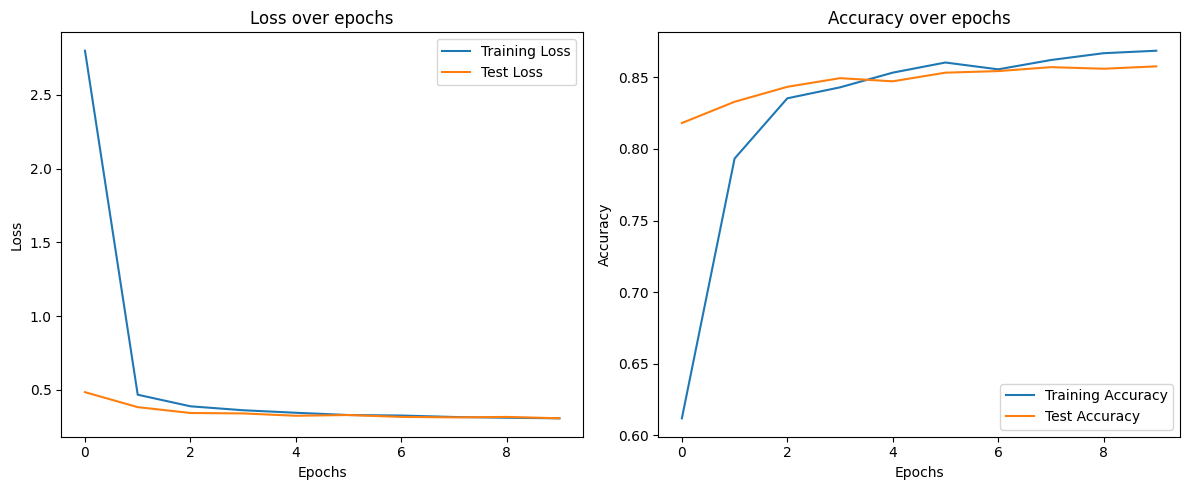


Final Results:
Best test accuracy: 0.8577
Achieved at epoch: 10


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 1. Load and prepare the dataset from TSV files
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 1. Load and prepare the dataset from TSV files
def load_tsv_dataset(file_path):
    df = pd.read_csv(file_path, sep='\t')
    
    # Print columns to see what we're working with
    print(f"Dataset columns: {df.columns.tolist()}")
    
    # Check the first few rows to understand the structure
    print("\nFirst 2 rows:")
    print(df.head(2))
    
    # Try to identify text and label columns based on common patterns
    text_col = None
    label_col = None
    
    # Common text column names
    text_candidates = ['sentence', 'text', 'review', 'content', 'phrase']
    for col in text_candidates:
        if col in df.columns:
            text_col = col
            break
    
    # Common label column names  
    label_candidates = ['label', 'sentiment', 'class', 'target']
    for col in label_candidates:
        if col in df.columns:
            label_col = col
            break
    
    # If we still can't identify columns, use position-based approach
    if text_col is None:
        # Assume the first column with string/object type is the text
        for col in df.columns:
            if df[col].dtype == 'object':
                text_col = col
                break
    
    if label_col is None:
        # Assume the first numeric column is the label
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                label_col = col
                break
    
    # If still can't identify, use first and last columns as fallback
    if text_col is None:
        text_col = df.columns[0]
    if label_col is None:
        label_col = df.columns[-1]
    
    print(f"\nUsing column '{text_col}' for text")
    print(f"Using column '{label_col}' for labels")
    
    texts = df[text_col].tolist()
    labels = df[label_col].tolist()
    
    return texts, labels

# Rest of the code remains the same...
# Load the train and test datasets
print("Loading training dataset...")
train_texts, train_labels = load_tsv_dataset('train.tsv')
print("Loading test dataset...")
test_texts, test_labels = load_tsv_dataset('test.tsv')

# 2. Generate embeddings using BertEmbedder
print(f"Generating embeddings for {len(train_texts)} training samples...")
train_embeddings = embedder.get_embeddings(train_texts)
print(f"Generating embeddings for {len(test_texts)} test samples...")
test_embeddings = embedder.get_embeddings(test_texts)

# Convert to PyTorch tensors
train_features = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_embeddings, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create dataset and dataloader
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 3. Define a simple classifier model
class BertClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        return self.classifier(x)

# Initialize the model
input_dim = embedder.embedding_size  # BERT base has 768 dimensions
num_classes = len(set(train_labels))  # Get number of unique classes
print(f"Number of classes: {num_classes}")

model = BertClassifier(input_dim, hidden_dim=128, num_classes=num_classes).to(device)

# 4. Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
num_epochs = 10
best_val_acc = 0

# Track metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# 5. Training loop with checkpointing
print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate training metrics
    epoch_loss = train_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation phase (using test data)
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate validation metrics
    epoch_val_loss = val_loss / len(test_loader)
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Test Loss: {epoch_val_loss:.4f}, Test Acc: {epoch_val_acc:.4f}")
    
    # Save checkpoint if validation accuracy improves
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc,
        }
        torch.save(checkpoint, 'checkpoint.pt')
        print(f"✓ Checkpoint saved! Best test accuracy: {best_val_acc:.4f}")

# 6. Plot the training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Load the best model and print final results
best_checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(best_checkpoint['model_state_dict'])
print(f"\nFinal Results:")
print(f"Best test accuracy: {best_checkpoint['val_acc']:.4f}")
print(f"Achieved at epoch: {best_checkpoint['epoch'] + 1}")

In [ ]:
imdb_train.head()

,text,label
10024,Painful. Painful is the only word to describe ...,0
11762,This is a cute little French silent comedy abo...,1
43345,I loved this show when it aired on television ...,1
33685,It pains me to write such a scathing review bu...,0
23647,"""Stairway to Heaven"" is a outstanding inventio...",1


## IMDB

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


# 1. Load and prepare the dataset from a DataFrame
def load_dataframe_dataset(df):
    # Print columns to see what we're working with
    print(f"Dataset columns: {df.columns.tolist()}")
    
    # Check the first few rows to understand the structure
    print("\nFirst 2 rows:")
    print(df.head(2))
    
    # Try to identify text and label columns based on common patterns
    text_col = None
    label_col = None
    
    # Common text column names
    text_candidates = ['text']
    for col in text_candidates:
        if col in df.columns:
            text_col = col
            break
    
    # Common label column names  
    label_candidates = ['label']
    for col in label_candidates:
        if col in df.columns:
            label_col = col
            break
    
    # If we still can't identify columns, use position-based approach
    if text_col is None:
        # Assume the first column with string/object type is the text
        for col in df.columns:
            if df[col].dtype == 'object':
                text_col = col
                break
    
    if label_col is None:
        # Assume the first numeric column is the label
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                label_col = col
                break
    
    # # If still can't identify, use first and last columns as fallback
    # if text_col is None:
    #     text_col = df.columns[0]
    # if label_col is None:
    #     label_col = df.columns[-1]
    
    print(f"\nUsing column '{text_col}' for text")
    print(f"Using column '{label_col}' for labels")
    
    texts = df[text_col].tolist()
    labels = df[label_col].tolist()
    
    return texts, labels

# Rest of the code remains the same...
# Load the train and test datasets
print("Loading training dataset...")
train_texts, train_labels = load_dataframe_dataset(imdb_train)
print("Loading test dataset...")
test_texts, test_labels = load_dataframe_dataset(imdb_val)

# 2. Generate embeddings using BertEmbedder
print(f"Generating embeddings for {len(train_texts)} training samples...")
train_embeddings = embedder.get_embeddings(train_texts)
print(f"Generating embeddings for {len(test_texts)} test samples...")
test_embeddings = embedder.get_embeddings(test_texts)

# Convert to PyTorch tensors
train_features = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_embeddings, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create dataset and dataloader
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



Loading training dataset...
Dataset columns: ['text', 'label']

First 2 rows:
                                                    text  label
10024  Painful. Painful is the only word to describe ...      0
11762  This is a cute little French silent comedy abo...      1

Using column 'text' for text
Using column 'label' for labels
Loading test dataset...
Dataset columns: ['text', 'label']

First 2 rows:
                                                    text  label
43072  Gayniggers from Outer Space is pretty much sum...      0
16416  This is a terrible production of Bartleby, tho...      0

Using column 'text' for text
Using column 'label' for labels
Generating embeddings for 40000 training samples...
Embedding on device: mps


In [ ]:
# 3. Define a simple classifier model
class BertClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        return self.classifier(x)

# Initialize the model
input_dim = embedder.embedding_size  # BERT base has 768 dimensions
num_classes = len(set(train_labels))  # Get number of unique classes
print(f"Number of classes: {num_classes}")
#use mps for mac m1/m2
device = torch.device("mps")
model = BertClassifier(input_dim, hidden_dim=128, num_classes=num_classes).to(device)

# 4. Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
num_epochs = 10
best_val_acc = 0

# Track metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# 5. Training loop with checkpointing
print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate training metrics
    epoch_loss = train_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation phase (using test data)
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate validation metrics
    epoch_val_loss = val_loss / len(test_loader)
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Test Loss: {epoch_val_loss:.4f}, Test Acc: {epoch_val_acc:.4f}")
    
    # Save checkpoint if validation accuracy improves
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc,
        }
        torch.save(checkpoint, 'checkpoint.pt')
        print(f"✓ Checkpoint saved! Best test accuracy: {best_val_acc:.4f}")

# 6. Plot the training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Load the best model and print final results
best_checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(best_checkpoint['model_state_dict'])
print(f"\nFinal Results:")
print(f"Best test accuracy: {best_checkpoint['val_acc']:.4f}")
print(f"Achieved at epoch: {best_checkpoint['epoch'] + 1}")

Loading training dataset...
Dataset columns: ['a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films', '1']

First 2 rows:
  a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films  \
0  apparently reassembled from the cutting room f...                                                        
1  they presume their audience wo n't sit still f...                                                        

   1  
0  0  
1  0  

Using column 'a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films' for text
Using column '1' for labels
Loading test dataset...
Dataset columns: ['no movement , no yuks , not much of anything', '0']

First 2 rows:
        no movement , no yuks , not much of anything  0
0  a gob of drivel so sickly sweet , even the eag...  0
1  gangs of new york is an unapologetic mess , wh...  0

Using column 'no movement , no yuks , not 

Epoch 1/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 2.8571, Train Acc: 0.6132, Test Loss: 0.4697, Test Acc: 0.8352
✓ Checkpoint saved! Best test accuracy: 0.8352


Epoch 2/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.4602, Train Acc: 0.7972, Test Loss: 0.3759, Test Acc: 0.8390
✓ Checkpoint saved! Best test accuracy: 0.8390


Epoch 3/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.3833, Train Acc: 0.8312, Test Loss: 0.3427, Test Acc: 0.8511
✓ Checkpoint saved! Best test accuracy: 0.8511


Epoch 4/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.3529, Train Acc: 0.8451, Test Loss: 0.3294, Test Acc: 0.8478


Epoch 5/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.3450, Train Acc: 0.8500, Test Loss: 0.3402, Test Acc: 0.8423


Epoch 6/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.3309, Train Acc: 0.8585, Test Loss: 0.3262, Test Acc: 0.8495


Epoch 7/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.3219, Train Acc: 0.8588, Test Loss: 0.3171, Test Acc: 0.8538
✓ Checkpoint saved! Best test accuracy: 0.8538


Epoch 8/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.3179, Train Acc: 0.8640, Test Loss: 0.3139, Test Acc: 0.8527


Epoch 9/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.3093, Train Acc: 0.8662, Test Loss: 0.3111, Test Acc: 0.8544
✓ Checkpoint saved! Best test accuracy: 0.8544


Epoch 10/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.3056, Train Acc: 0.8660, Test Loss: 0.3135, Test Acc: 0.8582
✓ Checkpoint saved! Best test accuracy: 0.8582


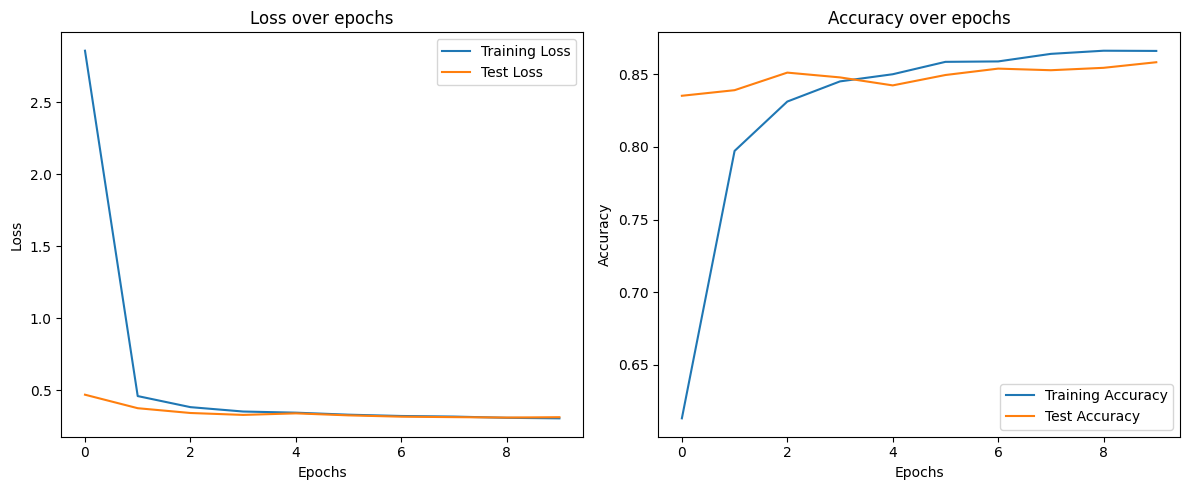


Final Results:
Best test accuracy: 0.8582
Achieved at epoch: 10


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 1. Load and prepare the dataset from TSV files
def load_tsv_dataset(file_path):
    df = pd.read_csv(file_path, sep='\t')
    
    # Print columns to see what we're working with
    print(f"Dataset columns: {df.columns.tolist()}")
    
    # Check the first few rows to understand the structure
    print("\nFirst 2 rows:")
    print(df.head(2))
    
    # Try to identify text and label columns based on common patterns
    text_col = None
    label_col = None
    
    # Common text column names
    text_candidates = ['sentence', 'text', 'review', 'content', 'phrase']
    for col in text_candidates:
        if col in df.columns:
            text_col = col
            break
    
    # Common label column names  
    label_candidates = ['label', 'sentiment', 'class', 'target']
    for col in label_candidates:
        if col in df.columns:
            label_col = col
            break
    
    # If we still can't identify columns, use position-based approach
    if text_col is None:
        # Assume the first column with string/object type is the text
        for col in df.columns:
            if df[col].dtype == 'object':
                text_col = col
                break
    
    if label_col is None:
        # Assume the first numeric column is the label
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                label_col = col
                break
    
    # If still can't identify, use first and last columns as fallback
    if text_col is None:
        text_col = df.columns[0]
    if label_col is None:
        label_col = df.columns[-1]
    
    print(f"\nUsing column '{text_col}' for text")
    print(f"Using column '{label_col}' for labels")
    
    texts = df[text_col].tolist()
    labels = df[label_col].tolist()
    
    return texts, labels

# Rest of the code remains the same...
# Load the train and test datasets
print("Loading training dataset...")
train_texts, train_labels = load_tsv_dataset('train.tsv')
print("Loading test dataset...")
test_texts, test_labels = load_tsv_dataset('test.tsv')


# Convert to PyTorch tensors
train_features = torch.tensor(train_embeddings, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_embeddings, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create dataset and dataloader
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 3. Define a simple classifier model
class BertClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        return self.classifier(x)

# Initialize the model
input_dim = embedder.embedding_size  # BERT base has 768 dimensions
num_classes = len(set(train_labels))  # Get number of unique classes
print(f"Number of classes: {num_classes}")

model = BertClassifier(input_dim, hidden_dim=128, num_classes=num_classes).to(device)

# 4. Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
num_epochs = 10
best_val_acc = 0

# Track metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# 5. Training loop with checkpointing
print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate training metrics
    epoch_loss = train_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation phase (using test data)
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate validation metrics
    epoch_val_loss = val_loss / len(test_loader)
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Test Loss: {epoch_val_loss:.4f}, Test Acc: {epoch_val_acc:.4f}")
    
    # Save checkpoint if validation accuracy improves
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc,
        }
        torch.save(checkpoint, 'checkpoint.pt')
        print(f"✓ Checkpoint saved! Best test accuracy: {best_val_acc:.4f}")

# 6. Plot the training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Load the best model and print final results
best_checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(best_checkpoint['model_state_dict'])
print(f"\nFinal Results:")
print(f"Best test accuracy: {best_checkpoint['val_acc']:.4f}")
print(f"Achieved at epoch: {best_checkpoint['epoch'] + 1}")

## Train the model with 10 epochs and create the best-performing model (checkpoint.pt) on the Dataset 1. (Doing for both embeddings)

Function to plot curves

In [ ]:
# Plot the training and validation loss curves
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(0, len(train_losses)), train_losses, label='Train loss', color='b')
    plt.plot(train_losses, label='Train loss', color='b')
    plt.scatter(range(0, len(val_losses)), val_losses, label='Validation loss', color='r')
    plt.plot(val_losses, label='Validation loss', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Training on BoW embeddings:

Train features shape: torch.Size([5536, 10000]), Train labels shape: torch.Size([5536])
Validation features shape: torch.Size([1384, 10000]), Validation labels shape: torch.Size([1384])
Test features shape: torch.Size([1821, 10000]), Test labels shape: torch.Size([1821])
Epoch 1/10, Train Loss: 2.4274, Val Loss: 1.4701, Val Acc: 0.6922
Epoch 2/10, Train Loss: 1.9148, Val Loss: 1.0321, Val Acc: 0.7818
Epoch 3/10, Train Loss: 1.5791, Val Loss: 0.9135, Val Acc: 0.7587
Epoch 4/10, Train Loss: 1.4156, Val Loss: 1.1896, Val Acc: 0.7645
Epoch 5/10, Train Loss: 1.3387, Val Loss: 1.3401, Val Acc: 0.7579
Epoch 6/10, Train Loss: 1.2830, Val Loss: 1.5231, Val Acc: 0.7652
Epoch 7/10, Train Loss: 1.2852, Val Loss: 1.5728, Val Acc: 0.7579
Epoch 8/10, Train Loss: 1.2407, Val Loss: 1.5901, Val Acc: 0.7659
Epoch 9/10, Train Loss: 1.2930, Val Loss: 1.6499, Val Acc: 0.7543
Epoch 10/10, Train Loss: 1.2556, Val Loss: 1.7674, Val Acc: 0.7579


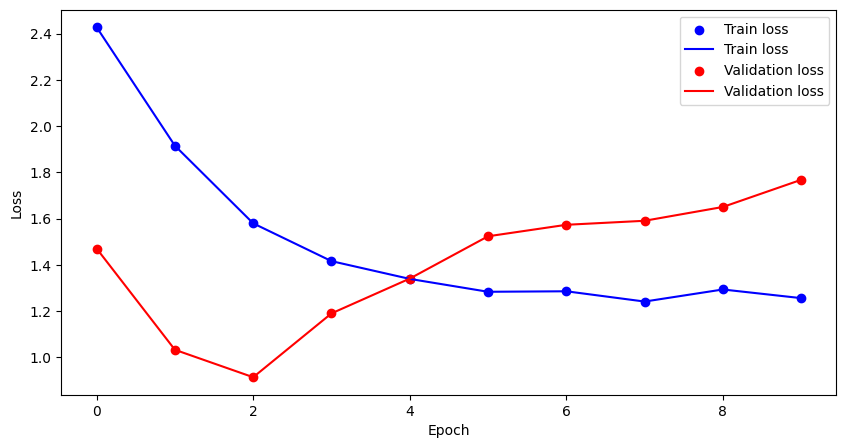

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gzip
import torch

# Instantiate the model
model = NeuralNetwork()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the batch size
batch_size = 32

# Verify the shapes of the features and labels
print(f"Train features shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test features shape: {test_features.shape}, Test labels shape: {test_labels.shape}")
# They should be torch.Size([num_samples, num_features]) and torch.Size([num_samples])

# Create Tensor datasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
n_epochs = 10
best_val_loss = float('inf')  # Track the best validation loss

trainloss=[]
valloss=[]

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        # Move data to device
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass & optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)  # Average training loss

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    trainloss.append(train_loss)
    valloss.append(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #torch.save(model.state_dict(), 'checkpoint.pt')
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }
        # Using gzip to compress the checkpoint file
        with gzip.open("checkpoint.pt.gz", "wb") as f:
            torch.save(checkpoint, f)

    # Print epoch results
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

plot_loss(trainloss, valloss)


Training on BERT embeddings:

## Using the checkpoint from before and train on the IMDB dataset (Dataset 2).

Loading the checkpoint for BoW embeddings:

In [ ]:
# Load the best model
#model.load_state_dict(torch.load('checkpoint.pt'))

# Gzip
with gzip.open("checkpoint.pt.gz", "rb") as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

C:\Users\Praanshu IIT\AppData\Local\Temp\ipykernel_16240\3071303538.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f, map_location=torch.device(

Training on BoW embeddings:

Epoch 1/5, Train Loss: 2.9478, Val Loss: 1.3607, Val Acc: 0.7517
Epoch 2/5, Train Loss: 1.7750, Val Loss: 0.7192, Val Acc: 0.8878
Epoch 3/5, Train Loss: 1.5656, Val Loss: 0.5980, Val Acc: 0.8963
Epoch 4/5, Train Loss: 1.4983, Val Loss: 0.5649, Val Acc: 0.8979
Epoch 5/5, Train Loss: 1.4679, Val Loss: 0.5716, Val Acc: 0.8963


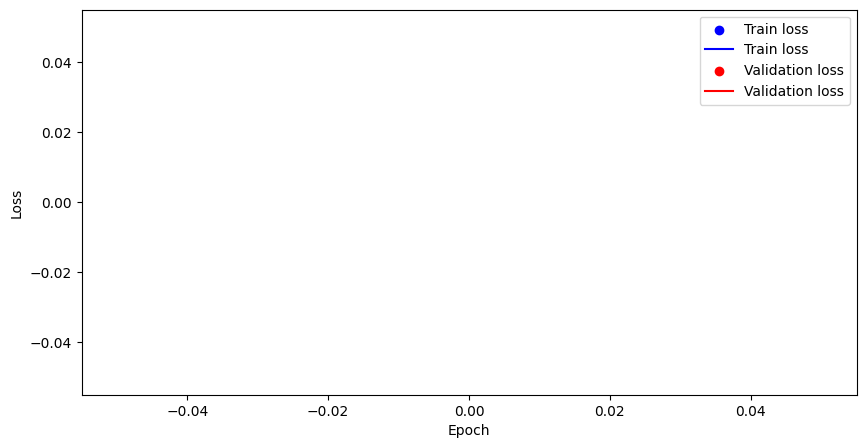

In [ ]:
# Use the checkpoint from before and train on the IMDB dataset (Dataset 2)

# Create Tensor datasets
imdb_train_dataset = TensorDataset(imdb_train_features, imdb_train_labels)
imdb_val_dataset = TensorDataset(imdb_val_features, imdb_val_labels)

# Create DataLoaders
imdb_train_loader = DataLoader(imdb_train_dataset, batch_size=batch_size, shuffle=True)
imdb_val_loader = DataLoader(imdb_val_dataset, batch_size=batch_size, shuffle=False)

n_epochs = 5
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Lower learning rate

trainloss=[]
valloss=[]

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, labels in imdb_train_loader:
        # Move data to device
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass & optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(imdb_train_loader)  # Average training loss

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in imdb_val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(imdb_val_loader)
    val_accuracy = correct / total

    trainloss.append(train_loss)
    valloss.append(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #torch.save(model.state_dict(), 'checkpoint_imdb.pt')
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }
        # Using gzip to compress the checkpoint file
        with gzip.open("checkpoint_imdb.pt.gz", "wb") as f:
            torch.save(checkpoint, f)

    # Print epoch results
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

plot_loss(trainloss, valloss)


Loading the checkpoint for BERT embeddings:

Training on BERT embeddings:

In [ ]:
# Load the best model
with gzip.open("checkpoint_imdb.pt.gz", "rb") as f:
    checkpoint = torch.load(f, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

C:\Users\Praanshu IIT\AppData\Local\Temp\ipykernel_16240\3166060105.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f, map_location=torch.device(

Evaluating on test data

Accuracy: 0.6716


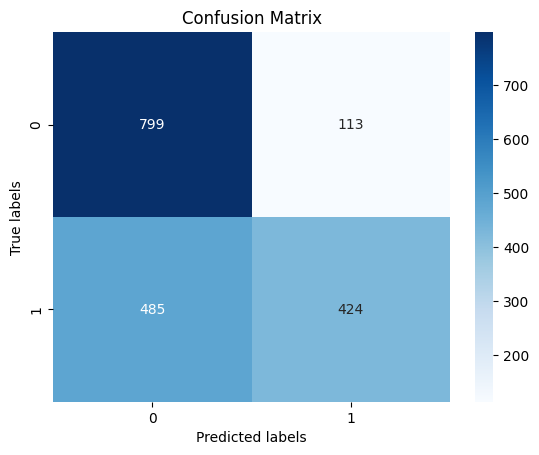

In [ ]:
# Evaluate the model on the test set
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Forward pass
        outputs = model(inputs)

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print the accuracy
accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()